In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
import os

In [2]:
# module for loading and preprocessing LIAR dataset
# arguments:
# train_path, valid_path, test_path - paths to LIAR dataset files
# return - tuple of (train_df, valid_df, test_df) with preprocessed data
def load_liar_dataset(train_path, valid_path, test_path):
    # step 1: define column names for LIAR dataset
    column_names = ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 
                   'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 
                   'mostly_true_counts', 'pants_on_fire_counts', 'context']
    
    # step 2: load datasets
    train_df = pd.read_csv(train_path, sep='\t', names=column_names)
    valid_df = pd.read_csv(valid_path, sep='\t', names=column_names)
    test_df = pd.read_csv(test_path, sep='\t', names=column_names)
    
    # step 3: convert labels to binary (0 for fake, 1 for real)
    # map 'pants-fire', 'false', 'barely-true' to fake (0)
    # map 'half-true', 'mostly-true', 'true' to real (1)
    label_map = {
        'pants-fire': 0, 'false': 0, 'barely-true': 0,
        'half-true': 1, 'mostly-true': 1, 'true': 1
    }
    
    # apply mapping to each dataset
    train_df['label'] = train_df['label'].map(label_map)
    valid_df['label'] = valid_df['label'].map(label_map)
    test_df['label'] = test_df['label'].map(label_map)
    
    # step 4: add source identifier
    train_df['source'] = 'liar'
    valid_df['source'] = 'liar'
    test_df['source'] = 'liar'
    
    return train_df, valid_df, test_df

# module for loading and preprocessing ISOT dataset
# arguments:
# fake_path - path to Fake.csv
# real_path - path to Real.csv
# test_split - fraction of data to use for testing (default: 0.2)
# valid_split - fraction of data to use for validation (default: 0.1)
# return - tuple of (train_df, valid_df, test_df) with preprocessed data
def load_isot_dataset(fake_path, real_path, test_split=0.2, valid_split=0.1):
    # step 1: load fake and real news
    fake_df = pd.read_csv(fake_path)
    real_df = pd.read_csv(real_path)
    
    # step 2: add binary labels (0 for fake, 1 for real)
    fake_df['label'] = 0
    real_df['label'] = 1
    
    # step 3: add source identifier
    fake_df['source'] = 'isot'
    real_df['source'] = 'isot'
    
    # step 4: combine text and title for ISOT dataset
    fake_df['statement'] = fake_df['title'] + " " + fake_df['text'] 
    real_df['statement'] = real_df['title'] + " " + real_df['text']
    
    # step 5: combine datasets
    combined_df = pd.concat([fake_df, real_df], ignore_index=True)
    
    # step 6: shuffle data
    combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # step 7: split into train, validation, and test sets
    test_size = int(len(combined_df) * test_split)
    valid_size = int(len(combined_df) * valid_split)
    
    test_df = combined_df[:test_size]
    valid_df = combined_df[test_size:test_size+valid_size]
    train_df = combined_df[test_size+valid_size:]
    
    return train_df, valid_df, test_df

In [3]:
# Enhanced dataset class that works with Trainer API and records source information
class FakeNewsDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        # step 1: extract data from dataframe
        self.texts = df['statement'].tolist()
        self.labels = df['label'].tolist()
        self.sources = df['source'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        # step 1: get text and label for the index
        text = self.texts[idx]
        label = self.labels[idx]
        
        # step 2: tokenize the text
        encodings = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # step 3: return the encodings and label
        # Note: we don't include source here as Trainer API doesn't support custom fields,
        # but we'll store it for later analysis
        return {
            'input_ids': encodings['input_ids'].squeeze(),
            'attention_mask': encodings['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }
    
    # Add method to get sources for dataset-aware evaluation
    def get_sources(self):
        return self.sources

In [4]:
# function to load, preprocess and combine both datasets
# arguments:
# liar_paths - tuple of (train_path, valid_path, test_path) for LIAR dataset
# isot_paths - tuple of (fake_path, real_path) for ISOT dataset
# return - tuple of (train_df, valid_df, test_df) with combined data
def combine_datasets(liar_paths, isot_paths):
    # step 1: load datasets
    liar_train, liar_valid, liar_test = load_liar_dataset(*liar_paths)
    isot_train, isot_valid, isot_test = load_isot_dataset(*isot_paths)
    
    # step 2: combine datasets
    train_df = pd.concat([liar_train, isot_train], ignore_index=True)
    valid_df = pd.concat([liar_valid, isot_valid], ignore_index=True)
    test_df = pd.concat([liar_test, isot_test], ignore_index=True)
    
    # step 3: shuffle data
    train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # step 4: print dataset statistics
    print("Dataset statistics:")
    print(f"  Train set: {len(train_df)} samples")
    print(f"    LIAR: {len(liar_train)} samples")
    print(f"    ISOT: {len(isot_train)} samples")
    print(f"  Validation set: {len(valid_df)} samples")
    print(f"    LIAR: {len(liar_valid)} samples")
    print(f"    ISOT: {len(isot_valid)} samples")
    print(f"  Test set: {len(test_df)} samples")
    print(f"    LIAR: {len(liar_test)} samples")
    print(f"    ISOT: {len(isot_test)} samples")
    
    return train_df, valid_df, test_df

In [5]:
# function to evaluate model with dataset awareness
# arguments:
# trainer - Trainer instance
# test_dataset - dataset to evaluate on
# return - dictionary with evaluation metrics
def evaluate_dataset_aware(trainer, test_dataset):
    # step 1: get overall metrics using trainer
    test_results = trainer.evaluate(test_dataset)
    
    # step 2: get dataset-specific metrics
    # Get predictions
    test_predictions = trainer.predict(test_dataset)
    predictions = np.argmax(test_predictions.predictions, axis=1)
    true_labels = test_predictions.label_ids
    sources = test_dataset.get_sources()
    
    # step 3: convert results to a more readable format
    readable_results = {}
    for key, value in test_results.items():
        # Extract the actual metric name from keys like 'eval_accuracy'
        if key.startswith('eval_'):
            metric_name = key[5:]  # Remove 'eval_' prefix
            readable_results[metric_name] = round(value, 4)  # Round to 4 decimal places
        else:
            readable_results[key] = value
    
    # step 4: calculate dataset-specific metrics
    dataset_metrics = {'overall': readable_results}
    
    for source in set(sources):
        # Get indices for this source
        source_indices = [i for i, s in enumerate(sources) if s == source]
        source_preds = [predictions[i] for i in source_indices]
        source_labels = [true_labels[i] for i in source_indices]
        
        # Calculate metrics for this source
        if len(source_indices) > 0 and len(set(source_labels)) > 1:
            source_metrics = {
                'accuracy': round(accuracy_score(source_labels, source_preds), 4),
                'precision': round(precision_score(source_labels, source_preds, zero_division=0), 4),
                'recall': round(recall_score(source_labels, source_preds), 4),
                'f1': round(f1_score(source_labels, source_preds), 4),
                'roc_auc': round(roc_auc_score(source_labels, source_preds), 4) if len(set(source_labels)) > 1 else 0
            }
            dataset_metrics[source] = source_metrics
    
    # step 5: display overall metrics table
    overall_metrics = pd.DataFrame({
        'Metric': list(readable_results.keys()),
        'Value': list(readable_results.values())
    })
    print("Overall Performance Metrics:")
    display(overall_metrics.set_index('Metric').transpose())
    
    # step 6: display source-specific metrics
    for source in dataset_metrics.keys():
        if source != 'overall':
            source_df = pd.DataFrame({
                'Metric': list(dataset_metrics[source].keys()),
                'Value': list(dataset_metrics[source].values())
            })
            print(f"\n{source.upper()} Dataset Performance Metrics:")
            display(source_df.set_index('Metric').transpose())
    
    # step 7: create overall confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"]).plot(cmap="Blues")
    plt.title("Overall Fake News Detection Confusion Matrix")
    plt.tight_layout()
    plt.show()
    
    # step 8: create source-specific confusion matrices
    for source in set(sources):
        source_indices = [i for i, s in enumerate(sources) if s == source]
        if len(source_indices) > 0:
            source_preds = [predictions[i] for i in source_indices]
            source_labels = [true_labels[i] for i in source_indices]
            
            cm = confusion_matrix(source_labels, source_preds)
            plt.figure(figsize=(8, 6))
            ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"]).plot(cmap="Blues")
            plt.title(f"{source.upper()} Dataset Fake News Detection Confusion Matrix")
            plt.tight_layout()
            plt.show()
    
    return dataset_metrics

Dataset statistics:
  Train set: 41670 samples
    LIAR: 10240 samples
    ISOT: 31430 samples
  Validation set: 5773 samples
    LIAR: 1284 samples
    ISOT: 4489 samples
  Test set: 10246 samples
    LIAR: 1267 samples
    ISOT: 8979 samples


Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training model...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,4034.274900,0.150010,0.915815,0.918870,0.906395,0.912590,0.915538
2,0.201800,0.152343,0.914602,0.875326,0.960700,0.916028,0.915959
3,0.137300,0.182318,0.915988,0.899517,0.930690,0.914838,0.916421
4,0.109200,0.266266,0.911831,0.884745,0.940693,0.911861,0.912680
5,0.066000,0.408894,0.910272,0.894227,0.924259,0.908995,0.910683



Evaluating model...


Overall Performance Metrics:


Metric,loss,accuracy,precision,recall,f1,roc_auc,runtime,samples_per_second,steps_per_second,epoch
Value,0.0845,0.9547,0.9322,0.9776,0.9543,0.9554,58.9909,173.688,10.866,5.0



ISOT Dataset Performance Metrics:


Metric,accuracy,precision,recall,f1,roc_auc
Value,0.9998,0.9998,0.9998,0.9998,0.9998



LIAR Dataset Performance Metrics:


Metric,accuracy,precision,recall,f1,roc_auc
Value,0.6354,0.6318,0.8459,0.7234,0.6047


<Figure size 800x600 with 0 Axes>

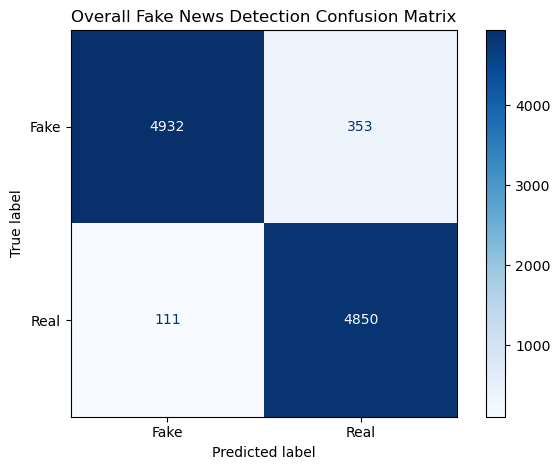

<Figure size 800x600 with 0 Axes>

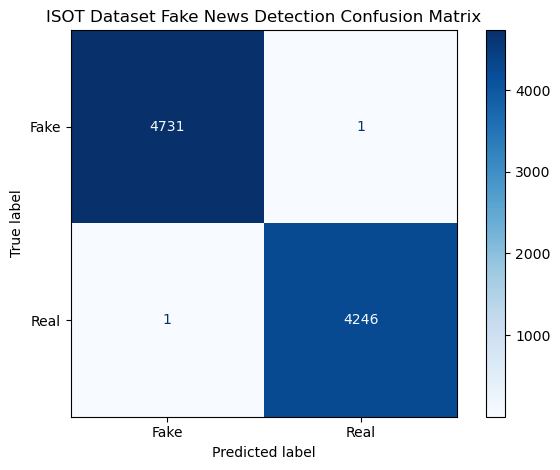

<Figure size 800x600 with 0 Axes>

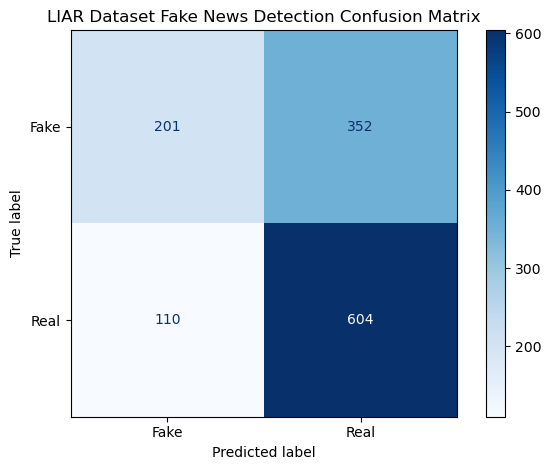


Model and tokenizer saved to mobilebert_fake_news_combined_final


In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# main function to run the pipeline
def run_fake_news_pipeline():
    # step 1: define paths
    liar_paths = (
        "data/liar_dataset/train.tsv",  # LIAR train path
        "data/liar_dataset/valid.tsv",  # LIAR validation path
        "data/liar_dataset/test.tsv"    # LIAR test path
    )
    
    isot_paths = (
        "data/isot_dataset/Fake.csv",   # ISOT fake news path
        "data/isot_dataset/True.csv"    # ISOT real news path
    )
    
    # step 2: load and combine datasets
    train_df, valid_df, test_df = combine_datasets(liar_paths, isot_paths)
    
    # step 3: initialize tokenizer
    tokenizer = AutoTokenizer.from_pretrained("google/mobilebert-uncased")
    
    # step 4: create dataset objects
    train_dataset = FakeNewsDataset(train_df, tokenizer)
    valid_dataset = FakeNewsDataset(valid_df, tokenizer)
    test_dataset = FakeNewsDataset(test_df, tokenizer)
    
    # step 5: define metrics computation function (same as your existing code)
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)
        
        return {
            'accuracy': accuracy_score(labels, predictions),
            'precision': precision_score(labels, predictions, zero_division=0),
            'recall': recall_score(labels, predictions),
            'f1': f1_score(labels, predictions),
            # Only compute ROC-AUC when we have both classes in the batch
            'roc_auc': roc_auc_score(labels, predictions) if len(np.unique(labels)) > 1 else 0
        }
    
    # step 6: load model
    model = AutoModelForSequenceClassification.from_pretrained("google/mobilebert-uncased", num_labels=2)
    
    # step 7: configure training arguments (same as your existing code)
    training_args = TrainingArguments(
        output_dir="v2_combined",
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=5,
        weight_decay=0.1,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        push_to_hub=False,
        report_to="none",
    )
    
    # step 8: initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        compute_metrics=compute_metrics,
    )
    
    # step 9: train model
    print("\nTraining model...")
    trainer.train()
    
    # step 10: evaluate with dataset awareness
    print("\nEvaluating model...")
    dataset_metrics = evaluate_dataset_aware(trainer, test_dataset)
    
    # step 11: save model
    model_path = "mobilebert_fake_news_combined_final"
    trainer.save_model(model_path)
    tokenizer.save_pretrained(model_path)
    print(f"\nModel and tokenizer saved to {model_path}")
    
    return trainer, dataset_metrics

# run the pipeline if this is the main script
if __name__ == "__main__":
    run_fake_news_pipeline()